<a href="https://colab.research.google.com/github/zw2788/LocalMinimaConstruction/blob/main/DwrtXGradientW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from typing import Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
from torch.autograd import grad


In [2]:
class SimpleNN(nn.Module):
    def __init__(self, custom_W_0, custom_b, custom_V_0, custom_c):
        super(SimpleNN, self).__init__()

        # Ensure that the custom weights are tensors
        custom_W_0 = torch.tensor(custom_W_0, dtype=torch.float64)
        custom_b = torch.tensor(custom_b, dtype=torch.float64)
        custom_V_0 = torch.tensor(custom_V_0, dtype=torch.float64)
        custom_c = torch.tensor(custom_c, dtype=torch.float64)

        # Set the custom weights and biases
        self.W_0 = nn.Parameter(custom_W_0)
        self.b = nn.Parameter(custom_b)
        self.V_0 = nn.Parameter(custom_V_0)
        self.c = nn.Parameter(custom_c)

    def forward(self, x):
        x = F.sigmoid(torch.add(torch.matmul(x, self.W_0), self.b))
        x = F.sigmoid(torch.add(torch.matmul(x, self.V_0), self.c))
        return x

# Example usage
#custom_W_0 = [[0.1, 0.2], [0.3, 0.4]]  # Replace with your own initial values
#custom_b = [0.1, 0.2]  # Replace with your own initial values
#custom_V_0 = [[0.1], [0.2]]  # Replace with your own initial values
#custom_c = [0.1]  # Replace with your own initial values


def calculate_second_order_grad(model, X_raw_torch, Y_torch):
    # Forward pass
    output = model(X_raw_torch)
    # Compute loss
    loss = -torch.mean(Y_torch * torch.log(output) + (1 - Y_torch) * torch.log(1 - output))
    # Compute gradients of the loss w.r.t. weights
    loss.backward(create_graph=True)
    # Combine and compute the norm of all gradients
    all_grads = torch.cat([param.grad.flatten() for param in model.parameters()])
    grad_norm = torch.norm(all_grads)
    #print(all_grads)
    # Compute the derivative of the grad_norm with respect to X
    second_order_grad = torch.autograd.grad(grad_norm, X_raw_torch, retain_graph=True)[0]
    return second_order_grad

def calculate_second_order_grad_trap(model, X_raw_torch, Y_torch):
    # Forward pass
    output = model(X_raw_torch)
    # Compute loss
    loss = -torch.mean(Y_torch * torch.log(output) + (1 - Y_torch) * torch.log(1 - output))
    # Compute gradients of the loss w.r.t. weights
    loss.backward(create_graph=True)
    # Combine and compute the norm of all gradients
    all_grads = torch.cat([param.grad.flatten() for param in model.parameters()])
    grad_norm = torch.norm(all_grads)
    #print(all_grads)
    # Compute the derivative of the grad_norm with respect to X
    second_order_grad = torch.autograd.grad(grad_norm, X_raw_torch, retain_graph=True)[0]
    return second_order_grad


In [ ]:
def perturb_weights_normal(model, max_deviation=0.01):
    with torch.no_grad():
        for param in model.parameters():
            std_dev = param.abs().mean() * max_deviation
            noise = torch.randn(param.size()) * std_dev
            param[:] = param + noise

def perturb_weights_uniform(model, max_deviation=0.01):
    with torch.no_grad():
        for param in model.parameters():
            scale_factor = param.abs().mean() * max_deviation
            # Generate uniform noise in the range [-scale_factor, scale_factor]
            noise = (torch.rand(param.size()) * 2 - 1) * scale_factor
            param[:] = param + noise
def perturb_weights_uniform_fixed_range(model, scale):
    with torch.no_grad():
        for param in model.parameters():
            # Generate uniform noise in the range [-0.1, 0.1]
            noise = (torch.rand(param.size()) * 2 - 1) * scale
            param[:] = param + noise

def restore_weights(model, saved_state):
    with torch.no_grad():
        for name, param in model.named_parameters():
            param[:] = saved_state[name]

def perturb_data(X, max_deviation=0.01):
    """Perturb the data tensor X."""
    with torch.no_grad():
        std_dev = X.abs().mean() * max_deviation
        noise = torch.randn(X.size()) * std_dev
        X.add_(noise)

In [5]:
# Re-executing the code to define the function for computing the Hessian matrix and its eigenvalues

def compute_hessian_and_eigenvalues(model, data, target):
    """
    Compute the Hessian matrix and its eigenvalues for the weights of a neural network model.

    :param model: The neural network model.
    :param data: Input data (X).
    :param target: Target data (Y).
    :return: Hessian matrix and its eigenvalues.
    """
    # Forward pass
    output = model(data)
    # Compute loss
    loss = -torch.mean(target * torch.log(output) + (1 - target) * torch.log(1 - output))

    # First-order gradients (w.r.t weights)
    first_order_grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)

    # Flatten the first-order gradients
    grads_flatten = torch.cat([g.contiguous().view(-1) for g in first_order_grads])

    # Hessian computation
    hessian = []
    for grad in grads_flatten:
        # Compute second-order gradients (w.r.t each element in the first-order gradients)
        second_order_grads = torch.autograd.grad(grad, model.parameters(), retain_graph=True)

        # Flatten and collect the second-order gradients
        hessian_row = torch.cat([g.contiguous().view(-1) for g in second_order_grads])
        hessian.append(hessian_row)

    # Stack to form the Hessian matrix
    hessian_matrix = torch.stack(hessian)

    # Compute eigenvalues
    eigenvalues, _ = torch.linalg.eig(hessian_matrix)

    return hessian_matrix, eigenvalues

# Note: To use this function, you'll need to provide your neural network model, the input data (X), and the target data (Y).


def check_local_minimum(eigenvalues):
    # Check if all eigenvalues have a positive real part
    if all(eig.real > 0 for eig in eigenvalues):
        print("This is a local minimum.")
    else:
        print("This is not a local minimum.")


In [19]:
# Function to plot a single tensor
def plot_tensor(tensor_data, label='Data', marker='o', color='blue'):
    plt.figure(figsize=(6, 4))

    # Plotting the tensor
    plt.scatter(tensor_data[:, 0].detach().numpy(), tensor_data[:, 1].detach().numpy(), label=label, marker=marker, color=color)

    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.title(f'{label} Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/zw2788/LocalMinimaConstruction/main/output(49830_100000).csv")

data.head()

# data , drop NaN values
X_raw,  Y, W_0, b, V_0, c = data[['x_2dvec']].dropna().values, data['y'].dropna().values, data[['W_0']].dropna().values, data[['b']].dropna().values, data[['V_0']].dropna().values, data[['c']].dropna().values

#convert string to array

X_raw = np.array([eval(s[0]) for s in X_raw])

W_0 = np.array([eval(s[0]) for s in W_0])

b = np.array([eval(s[0]) for s in b])

V_0 = np.array([eval(s[0]) for s in V_0])

c = np.array([eval(s[0]) for s in c])

# Standardize the input
# Leave blank to match the example in paper

# formatting
Y = Y.reshape((-1, 1))
print(X_raw)
print(Y)
print(W_0)
#print(X_raw.shape[0])
X_raw = torch.tensor(X_raw, requires_grad=True)
Y = torch.tensor(Y)
print(W_0, b, V_0, c)

[[-4.05673409 -1.57919633]
 [-4.08621693 -7.32655954]
 [ 5.7382369   6.51035595]
 [-3.54674959 -9.48523903]
 [-5.44635487 -1.49153161]
 [-3.05762291  7.25649118]
 [-9.07657528  3.435395  ]
 [-3.56827617 -2.80349135]
 [ 4.2420435   2.56337643]
 [-8.37438869  4.51332331]]
[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 3.37760234 -8.4564867 ]
 [ 0.92768544  2.91912866]]
[[ 3.37760234 -8.4564867 ]
 [ 0.92768544  2.91912866]] [[ 4.70377207 -0.07312825]] [[ 4.8233037 ]
 [-4.45070505]] [[-4.8279748]]


In [6]:
nn_model = SimpleNN(W_0, b, V_0, c)
hessian_matrix_initial, eigenvalues_initial = compute_hessian_and_eigenvalues(nn_model, X_raw, Y)

print(eigenvalues_initial)
check_local_minimum(eigenvalues_initial)

tensor([-3.2549e+00+0.j,  1.0070e-01+0.j,  8.7098e-03+0.j,  1.8168e-03+0.j,
        -2.7687e-04+0.j,  4.1569e-05+0.j, -6.5372e-09+0.j,  1.3711e-10+0.j,
        -4.7058e-13+0.j], dtype=torch.complex128)
This is not a local minimum.


before tensor([[-4.0567, -1.5792],
        [-4.0862, -7.3266],
        [ 5.7382,  6.5104],
        [-3.5467, -9.4852],
        [-5.4464, -1.4915],
        [-3.0576,  7.2565],
        [-9.0766,  3.4354],
        [-3.5683, -2.8035],
        [ 4.2420,  2.5634],
        [-8.3744,  4.5133]], dtype=torch.float64, requires_grad=True)
tensor(0.0011, dtype=torch.float64, grad_fn=<SubBackward0>)
before tensor([[-4.0568, -1.5792],
        [-4.0862, -7.3266],
        [ 5.7382,  6.5104],
        [-3.8816, -9.3696],
        [-5.4464, -1.4915],
        [-3.0566,  7.2568],
        [-9.0766,  3.4354],
        [-3.5683, -2.8035],
        [ 4.2420,  2.5634],
        [-8.3744,  4.5133]], dtype=torch.float64, requires_grad=True)
tensor(-0.0408, dtype=torch.float64, grad_fn=<SubBackward0>)
acheive! at:0
tensor([[-4.0568, -1.5792],
        [-4.0862, -7.3266],
        [ 5.7382,  6.5104],
        [-3.8816, -9.3696],
        [-5.4464, -1.4915],
        [-3.0566,  7.2568],
        [-9.0766,  3.4354],
        [-3

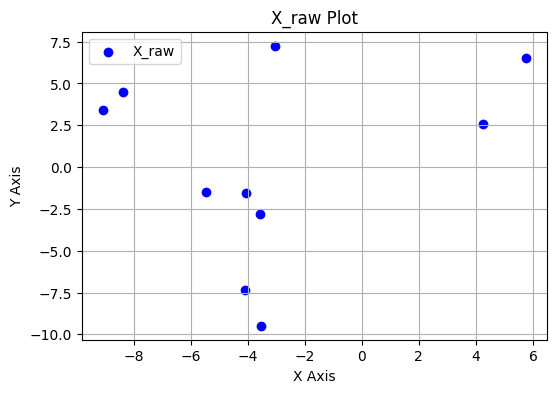

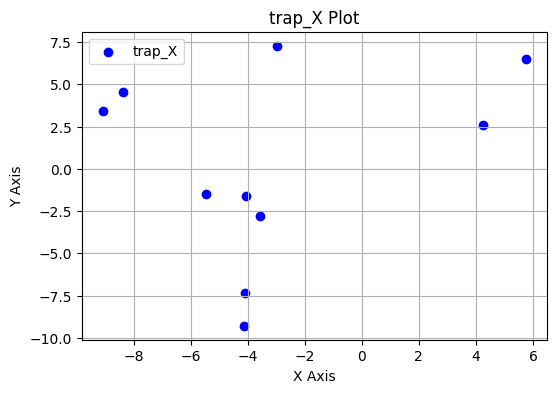

In [20]:
# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)

def make_model_copy(original_model):
    # Create a new instance of the model
    model_copy = SimpleNN(W_0, b, V_0, c)  # Use the same parameters as used to create the original model
    # Copy the initial weights from the original model
    model_copy.load_state_dict(original_model.state_dict())
    return model_copy

def trap_model(original_model, X, Y, max_iterations, number_of_x_iterations, weightlr=0.01, xlr=0.01):
    X_modifiable = X.clone().detach().requires_grad_(True)

    for current_iteration in range(max_iterations):
        # Use a fresh copy of the model
        model = make_model_copy(original_model)

        optimizer_weights = optim.SGD(model.parameters(), lr=weightlr)

    # Optimizer for the weights
    #optimizer_weights = optim.SGD(model.parameters(), lr=weightlr)

        # Save initial state of the model
        initial_state_dict = model.state_dict()

        # Load initial weights using the deep copied state
        model.load_state_dict(copy.deepcopy(initial_state_dict))

        # Reset the optimizer state
        optimizer_weights = optim.SGD(model.parameters(), lr=weightlr)

        # Forward pass with current X_modifiable and initial weights
        model_output = model(X_modifiable)

        old_loss = -torch.mean(Y * torch.log(model_output) + (1 - Y) * torch.log(1 - model_output))

        # Gradient descent step for weights
        optimizer_weights.zero_grad()
        old_loss.backward()
        optimizer_weights.step()
        # Gather all gradients into a list after flattening
        gradients = [param.grad.view(-1) for param in model.parameters() if param.grad is not None]

        # Concatenate all gradients to form a single vector and calculate its norm
        total_gradient = torch.cat(gradients)
        total_gradient_norm = total_gradient.norm()

        # Check if the combined gradient norm is below the threshold
        if total_gradient_norm < 1e-8:
            print("Combined gradient norm below threshold, stopping optimization.")
            break

        # Save new weights and create a copy of X_modifiable for the inner loop
        new_state_dict = model.state_dict()
        X_inner = X_modifiable.clone().detach().requires_grad_(True)
        optimizer_x = optim.SGD([X_inner], lr=xlr)

        for _ in range(number_of_x_iterations):
            # Load new weights
            model.load_state_dict(new_state_dict)
            print("before {}".format(X_inner))
            output_new = model(X_inner)
            new_loss = -torch.mean(Y * torch.log(output_new) + (1 - Y) * torch.log(1 - output_new))

            # Calculate combined loss
            combined_loss = old_loss.detach() - new_loss
            print(combined_loss)


            # Check condition
            if combined_loss <= 0:
                print("acheive! at:{}".format(current_iteration))
                print(X_inner)
                break
            else:
                optimizer_x.zero_grad()
                combined_loss.backward()
                optimizer_x.step()
        #print(X_inner.data)
        # Update X_modifiable with changes from the inner loop
        # Calculate the difference between X_modifiable and X_inner
        difference = (X_modifiable - X_inner).norm()

        # Check if the difference is below a certain threshold
        if difference < 1e-8:  # You can adjust this threshold as needed
          print("X_modifiable did not change significantly, stopping early.")
          break
        else:

          # Update X_modifiable with changes from the inner loop
          X_modifiable.data = X_inner.data


    # After completing all iterations, load initial weights
    model.load_state_dict(initial_state_dict)

    # Forward pass with the final X_modifiable and initial weights
    final_output = model(X_modifiable)
    final_loss = -torch.mean(Y * torch.log(final_output) + (1 - Y) * torch.log(1 - final_output))

    # Calculate gradients with respect to the initial weights
    optimizer_weights.zero_grad()
    final_loss.backward()

    # Calculate and print the norm of the gradients for each parameter
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Gradient norm for {name}: {param.grad.norm().item()}")

    # Return the modified X
    return X_modifiable

# Initialize your model, X, Y, etc. outside the function
# ... [Your initialization code here] ...

# Call the function
# ... [Call to train_model function here] ...
#Example
# Initialize your model, X, Y, etc. outside the function
#custom_W_0 = [...]  # Replace [...] with your initial weights
#custom_b = [...]   # Replace [...] with your initial bias
#custom_V_0 = [...]  # Replace [...] with your next layer weights
#custom_c = [...]   # Replace [...] with your next layer bias
#model = SimpleNN(custom_W_0, custom_b, custom_V_0, custom_c)
#X = torch.tensor([...], dtype=torch.float64, requires_grad=True)  # Replace [...] with your initial data
#Y = torch.tensor([...], dtype=torch.float64)  # Replace [...] with target data

# Call the function
nn_model_trap = SimpleNN(W_0, b, V_0, c)
trap_X = trap_model(nn_model_trap, X_raw, Y, max_iterations=10, number_of_x_iterations=10, weightlr= 0.005, xlr= 1)
plot_tensor(X_raw, label='X_raw', marker='o', color='blue')
plot_tensor(trap_X, label='trap_X', marker='o', color='blue')

In [15]:
print(X_raw)
print(trap_X)
hessian_matrix_trap, eigenvalues_trap = compute_hessian_and_eigenvalues(nn_model_trap, trap_X, Y)

print(eigenvalues_trap)
check_local_minimum(eigenvalues_trap)

tensor([[-4.0567, -1.5792],
        [-4.0862, -7.3266],
        [ 5.7382,  6.5104],
        [-3.5467, -9.4852],
        [-5.4464, -1.4915],
        [-3.0576,  7.2565],
        [-9.0766,  3.4354],
        [-3.5683, -2.8035],
        [ 4.2420,  2.5634],
        [-8.3744,  4.5133]], dtype=torch.float64, requires_grad=True)
tensor([[-4.3286, -1.6539],
        [-4.0862, -7.3266],
        [ 5.7382,  6.5104],
        [-4.6614, -9.1004],
        [-5.4464, -1.4915],
        [-1.5847,  7.6610],
        [-9.0766,  3.4354],
        [-3.5682, -2.8035],
        [ 4.2420,  2.5634],
        [-8.3744,  4.5133]], dtype=torch.float64, requires_grad=True)
tensor([ 1.0231e-01+0.j,  1.1700e-03+0.j, -5.3397e-04+0.j, -1.1300e-04+0.j,
         3.1105e-05+0.j, -1.3220e-04+0.j, -6.0797e-10+0.j,  1.0024e-11+0.j,
        -8.7358e-13+0.j], dtype=torch.complex128)
This is not a local minimum.


In [ ]:
def optimize_data_with_centralgradients(X_raw, Y, W_0, b, V_0, c, max_iterations=20, learning_rate=0.1,  threshold=0.001):
    """
    Optimize data using gradient calculations and Monte Carlo method.

    :param nn_model: Neural Network Model class.
    :param X_raw: Input data.
    :param Y: Target data.
    :param W_0, b, V_0, c: Initial weights and biases for the neural network.
    :param max_iterations: Maximum number of iterations.
    :param learning_rate: Learning rate for optimization.
    :param MC_num_samples: Number of samples for Monte Carlo method.
    :param surrounding_proportion: Proportion of surrounding points' gradients.
    :param max_deviation_for_weight: Maximum deviation for weight perturbation.
    :param threshold: Threshold for the norm of the second-order gradient.
    :return: Optimized X_raw tensor.
    """

    # Convert data to PyTorch tensors
    X_raw_tensor = X_raw.clone().detach().requires_grad_(True) if X_raw.requires_grad else torch.tensor(X_raw, dtype=torch.float64, requires_grad=True)
    Y_tensor = Y.clone().detach().requires_grad_(True) if Y.requires_grad else torch.tensor(Y, dtype=torch.float64, requires_grad=True)


    # Initialize the neural network with provided weights
    nn_model_instance = SimpleNN(W_0, b, V_0, c)

    # Store original weights
    original_weights = {
        'W_0': nn_model_instance.W_0.data.clone(),
        'b': nn_model_instance.b.data.clone(),
        'V_0': nn_model_instance.V_0.data.clone(),
        'c': nn_model_instance.c.data.clone()
    }
    print("Original weight is {}".format(original_weights))
    print("Initial X_raw_pre {}".format(X_raw_tensor))

    for i in range(max_iterations):
        # [Insert the existing logic of your loop here, using nn_model_instance, X_raw_tensor, Y_tensor, and other parameters]
        # Calculate the gradient at the central point
        central_grad = calculate_second_order_grad(nn_model_instance, X_raw_tensor, Y_tensor)
        # Check if grad_X is None before proceeding
        central_grad_norm = torch.norm(central_grad)
        central_grad = central_grad / central_grad_norm
        #print(central_grad)
        # Surrouning points' grads
        surrounding_grads_pre = []
        norms_pre = []
        negative_eigenvalues = []


        # Combine gradients
        combined_grad = central_grad
        #combined_grad =  average_surrounding_grad
        #print(combined_grad)
        # Calculate the norm of the combined gradient
        combined_grad_norm = torch.norm(combined_grad)

        # Check for a non-zero norm to avoid division by zero
        if combined_grad_norm == 0:
        # Normalize the gradient
          print("Gradient is zero; no update required.")

###############

        # Check if the norm of the second-order gradient is below the threshold
        if torch.norm(combined_grad) < threshold:
            print(f"Convergence reached at iteration {i}")
            break
        # Update X_raw using the normalized gradient and learning rate
        X_raw_tensor.data -= learning_rate * combined_grad_norm

        # Zero out gradients for the next iteration
        nn_model_instance.zero_grad()
        X_raw_tensor.grad = None
        # Update and checks as per your original code



    # Print final modified data

    print("Output X is: {}".format(X_raw_tensor))


    print(central_grad_norm)
    # Return the optimized X_raw tensor
    return X_raw_tensor

# Example usage
optimized_X_1 = optimize_data_with_centralgradients(trap_X, Y, W_0, b, V_0, c, max_iterations=1000, learning_rate=0.001,  threshold=0.0001)


<ipython-input-27-fb3eef455826>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = Y.clone().detach().requires_grad_(True) if Y.requires_grad else torch.tensor(Y, dtype=torch.float64, requires_grad=True)


Original weight is {'W_0': tensor([[-0.9854, -7.0746],
        [-0.7950, -5.9667]], dtype=torch.float64), 'b': tensor([[2.9537, 2.3977]], dtype=torch.float64), 'V_0': tensor([[-8.6610],
        [-6.9776]], dtype=torch.float64), 'c': tensor([[6.6996]], dtype=torch.float64)}
Initial X_raw_pre tensor([[ 0.1222,  0.1974],
        [ 0.6699,  1.4908],
        [ 0.1828,  0.1296],
        [-3.1624, -3.5892],
        [ 0.2212,  0.0867],
        [ 0.2715, -0.6380],
        [ 0.7825,  1.3818],
        [ 1.3966,  3.5302],
        [ 0.2329,  0.0736],
        [ 2.6141, -0.3701]], dtype=torch.float64, requires_grad=True)
Output X is: tensor([[-0.8778, -0.8026],
        [-0.3301,  0.4908],
        [-0.8172, -0.8704],
        [-4.1624, -4.5892],
        [-0.7788, -0.9133],
        [-0.7285, -1.6380],
        [-0.2175,  0.3818],
        [ 0.3966,  2.5302],
        [-0.7671, -0.9264],
        [ 1.6141, -1.3701]], dtype=torch.float64, requires_grad=True)
tensor(0.2884, dtype=torch.float64)


In [ ]:
nn_model = SimpleNN(W_0, b, V_0, c)
hessian_matrix_central, eigenvalues_central = compute_hessian_and_eigenvalues(nn_model, optimized_X_1, Y)

print(eigenvalues_central)
check_local_minimum(eigenvalues_central)

tensor([ 8.5687e-01+0.j, -8.2876e-02+0.j,  4.8516e-02+0.j,  1.3709e-02+0.j,
         3.4205e-03+0.j, -2.7478e-03+0.j,  3.2365e-04+0.j,  1.6174e-04+0.j,
        -7.9576e-06+0.j], dtype=torch.complex128)
This is not a local minimum.


In [ ]:
def optimize_data_with_gradients(X_raw, Y, W_0, b, V_0, c, max_iterations=20, learning_rate=0.1, MC_num_samples=100, surrounding_proportion=0.5, max_deviation_for_weight=0.05, threshold=0.001):
    """
    Optimize data using gradient calculations and Monte Carlo method.

    :param nn_model: Neural Network Model class.
    :param X_raw: Input data.
    :param Y: Target data.
    :param W_0, b, V_0, c: Initial weights and biases for the neural network.
    :param max_iterations: Maximum number of iterations.
    :param learning_rate: Learning rate for optimization.
    :param MC_num_samples: Number of samples for Monte Carlo method.
    :param surrounding_proportion: Proportion of surrounding points' gradients.
    :param max_deviation_for_weight: Maximum deviation for weight perturbation.
    :param threshold: Threshold for the norm of the second-order gradient.
    :return: Optimized X_raw tensor.
    """

    # Convert data to PyTorch tensors
    X_raw_tensor = X_raw.clone().detach().requires_grad_(True) if X_raw.requires_grad else torch.tensor(X_raw, dtype=torch.float64, requires_grad=True)
    Y_tensor = Y.clone().detach().requires_grad_(True) if Y.requires_grad else torch.tensor(Y, dtype=torch.float64, requires_grad=True)


    # Initialize the neural network with provided weights
    nn_model_sur = SimpleNN(W_0, b, V_0, c)

    # Store original weights
    original_weights = {
        'W_0': nn_model_sur.W_0.data.clone(),
        'b': nn_model_sur.b.data.clone(),
        'V_0': nn_model_sur.V_0.data.clone(),
        'c': nn_model_sur.c.data.clone()
    }
    print("Original weight is {}".format(original_weights))
    print("Initial X_raw_pre {}".format(X_raw_tensor))

    for i in range(max_iterations):
        # [Insert the existing logic of your loop here, using nn_model_instance, X_raw_tensor, Y_tensor, and other parameters]
        # Calculate the gradient at the central point
        central_grad = calculate_second_order_grad(nn_model_sur, X_raw_tensor, Y_tensor)
        # Check if grad_X is None before proceeding
        central_grad_norm = torch.norm(central_grad)
        central_grad = central_grad / central_grad_norm
        #print(central_grad)
        # Surrouning points' grads
        surrounding_grads_pre = []
        norms_pre = []


        # Calculate the gradient at the surrounding points by MC
        for _ in range(MC_num_samples):

            nn_model_sample_pre = SimpleNN(custom_W_0=original_weights['W_0'],custom_b=original_weights['b'],custom_V_0=original_weights['V_0'],custom_c=original_weights['c'])
            #print("W_0 (before perturbation):", nn_model_sample.W_0.data)
            # Perturb weights
            #perturb_weights_uniform_fixed_range(nn_model_sample, max_deviation=max_deviation_for_weight)
            perturb_weights_uniform_fixed_range(nn_model_sample_pre, scale = max_deviation_for_weight)
            #print("W_0 (after perturbation):", nn_model_sample.W_0.data)
            grad_pre = calculate_second_order_grad(nn_model_sample_pre, X_raw_tensor, Y_tensor)
            grad_norm = torch.norm(grad_pre)
            grad_pre = grad_pre / grad_norm
            surrounding_grads_pre.append(grad_pre)
            #negative_eigenvalues.append(torch.norm(grad_pre).item())

        sum_surrounding_grads_pre = sum(surrounding_grads_pre)

        # Average the large norm gradients
        average_surrounding_grads_pre = sum_surrounding_grads_pre / len(surrounding_grads_pre)
        # Calculate average pre_norm
        #average_negative_eigenvalues = sum(negative_eigenvalues) / len(negative_eigenvalues)

        # Calculate the median of negative eigenvalues
        #median_negative_eigenvalue = np.median([eigenvalue for eigenvalue in negative_eigenvalues if eigenvalue < 0])


        # Filter gradients corresponding to the smallest 50% of negative eigenvalues
        #above_average_negative_eigenvalues = [grad for grad, eigenvalue in zip(surrounding_grads_pre, negative_eigenvalues) if eigenvalue < median_negative_eigenvalue]
        #above_average_negative_eigenvalues = [grad / torch.norm(grad) for grad in above_average_negative_eigenvalues]

        #print(above_average_grads)
        #sum_above_average_negative_eigenvalues = sum(above_average_negative_eigenvalues)

        # Average the large norm gradients
        #if above_average_negative_eigenvalues:
          #average_above_average_negative_eigenvalues = sum_above_average_negative_eigenvalues / len(above_average_negative_eigenvalues)
          #print(average_above_average_grad)
        #else:
          # Handle the case where no gradient is above average
          #average_above_average_negative_eigenvalues = torch.zeros_like(X_raw_tensor)


        #print("Surrounding grad {}".format(surrounding_grads))

        # Combine gradients
        combined_grad = (1-surrounding_proportion) * central_grad + surrounding_proportion * average_surrounding_grads_pre
        #combined_grad =  average_surrounding_grad
        #print(combined_grad)
        # Calculate the norm of the combined gradient
        combined_grad_norm = torch.norm(combined_grad)

        # Check for a non-zero norm to avoid division by zero
        if combined_grad_norm > 0:
        # Normalize the gradient
          normalized_grad = combined_grad / combined_grad_norm

        else:
          print("Gradient is zero; no update required.")
###############

        # Check if the norm of the second-order gradient is below the threshold
        if torch.norm(combined_grad) < threshold:
            print(f"Convergence reached at iteration {i}")
            break
        # Update X_raw using the normalized gradient and learning rate
        X_raw_tensor.data -= learning_rate * normalized_grad

        # Zero out gradients for the next iteration
        nn_model_sur.zero_grad()
        X_raw_tensor.grad = None
        # Update and checks as per your original code



    # Print final modified data
    #print(surrounding_grads)
    #print("Final modified X_raw:")
    #if len(above_average_negative_eigenvalues) < 0.5*MC_pre_num_samples:
      #print("need more MC_pre_num_samples")
    #else:
    #print("Used surrounding points: {}".format(len(above_average_negative_eigenvalues)))

    print("Output X is: {}".format(X_raw_tensor))
    #print(negative_eigenvalues)



    # Return the optimized X_raw tensor
    return X_raw_tensor

# Example usage
optimized_X_2 = optimize_data_with_gradients(trap_X, Y, W_0, b, V_0, c, max_iterations=50, learning_rate=0.1, MC_num_samples=100, surrounding_proportion=0.3, max_deviation_for_weight=0.01, threshold=0.001)


<ipython-input-29-5816f8b1477c>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = Y.clone().detach().requires_grad_(True) if Y.requires_grad else torch.tensor(Y, dtype=torch.float64, requires_grad=True)
<ipython-input-3-2e4822dd5dc3>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  custom_W_0 = torch.tensor(custom_W_0, dtype=torch.float64)
<ipython-input-3-2e4822dd5dc3>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  custom_b = torch.tensor(custom_b, dtype=torch.float64)
<ipython-input-3-2e4822dd5dc3>:8: UserWarning: To copy c

Original weight is {'W_0': tensor([[-0.9854, -7.0746],
        [-0.7950, -5.9667]], dtype=torch.float64), 'b': tensor([[2.9537, 2.3977]], dtype=torch.float64), 'V_0': tensor([[-8.6610],
        [-6.9776]], dtype=torch.float64), 'c': tensor([[6.6996]], dtype=torch.float64)}
Initial X_raw_pre tensor([[ 0.1222,  0.1974],
        [ 0.6699,  1.4908],
        [ 0.1828,  0.1296],
        [-3.1624, -3.5892],
        [ 0.2212,  0.0867],
        [ 0.2715, -0.6380],
        [ 0.7825,  1.3818],
        [ 1.3966,  3.5302],
        [ 0.2329,  0.0736],
        [ 2.6141, -0.3701]], dtype=torch.float64, requires_grad=True)
Output X is: tensor([[-0.1250, -0.0626],
        [ 0.2896,  1.2047],
        [-0.0676, -0.1333],
        [-3.1624, -3.5891],
        [-0.0313, -0.1780],
        [ 0.2775, -0.6330],
        [ 0.3866,  1.0816],
        [ 4.3140,  5.7800],
        [-0.0203, -0.1916],
        [ 1.9599, -0.9091]], dtype=torch.float64, requires_grad=True)


In [ ]:
nn_model_X2 = SimpleNN(W_0, b, V_0, c)
hessian_matrix_surrounding, eigenvalues_surrounding = compute_hessian_and_eigenvalues(nn_model_X2, optimized_X_2, Y)

print(eigenvalues_surrounding)
check_local_minimum(eigenvalues_surrounding)

tensor([ 0.3254+0.j,  0.2093+0.j, -0.1277+0.j, -0.0679+0.j,  0.0189+0.j,  0.0015+0.j,
        -0.0028+0.j, -0.0007+0.j, -0.0010+0.j], dtype=torch.complex128)
This is not a local minimum.


In [ ]:
optimized_X_2 = optimize_data_with_gradients(optimized_X_1, Y, W_0, b, V_0, c, max_iterations=20, learning_rate=0.05, MC_num_samples=100, surrounding_proportion=0.9, max_deviation_for_weight=0.02, threshold=0.001)

<ipython-input-19-1e9be29dee3d>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_raw_tensor = torch.tensor(X_raw, requires_grad=True)
<ipython-input-19-1e9be29dee3d>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y)
<ipython-input-3-a815e9696fa5>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  custom_W_0 = torch.tensor(custom_W_0, dtype=torch.float64)
<ipython-input-3-a815e9696fa5>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Original weight is {'W_0': tensor([[ 3.9979,  5.2638],
        [ 1.0698, -1.8901]], dtype=torch.float64), 'b': tensor([[1.8545, 0.8022]], dtype=torch.float64), 'V_0': tensor([[-10.1389],
        [-10.4242]], dtype=torch.float64), 'c': tensor([[5.0116]], dtype=torch.float64)}
Initial X_raw_pre tensor([[11.0898, -7.6508],
        [ 1.6931, -6.0680],
        [ 4.9975, -0.8779],
        [ 6.1208, -5.1308],
        [-5.5432, -6.2103],
        [ 1.1082,  0.1752],
        [-7.4783,  0.5124],
        [-7.9947,  0.8285],
        [-1.3351,  2.2657],
        [-3.4568,  2.3168]], dtype=torch.float64, requires_grad=True)
Used surrounding points: 50
Output X is: tensor([[11.0898, -7.6508],
        [ 1.6931, -6.0680],
        [ 4.9975, -0.8779],
        [ 6.1208, -5.1308],
        [-5.5432, -6.2103],
        [ 1.1082,  0.1752],
        [-7.4783,  0.5124],
        [-7.9947,  0.8285],
        [-1.3568,  2.0730],
        [-3.4338,  2.3244]], dtype=torch.float64, requires_grad=True)
[tensor(-0.0003, dtyp

In [ ]:
optimized_X_3 = optimize_data_with_gradients(optimized_X_2, Y, W_0, b, V_0, c, max_iterations=20, learning_rate=0.02, MC_num_samples=100, surrounding_proportion=0.9, max_deviation_for_weight=0.01, threshold=0.001)

<ipython-input-19-1e9be29dee3d>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_raw_tensor = torch.tensor(X_raw, requires_grad=True)
<ipython-input-19-1e9be29dee3d>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y)
<ipython-input-3-a815e9696fa5>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  custom_W_0 = torch.tensor(custom_W_0, dtype=torch.float64)
<ipython-input-3-a815e9696fa5>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Original weight is {'W_0': tensor([[ 3.9979,  5.2638],
        [ 1.0698, -1.8901]], dtype=torch.float64), 'b': tensor([[1.8545, 0.8022]], dtype=torch.float64), 'V_0': tensor([[-10.1389],
        [-10.4242]], dtype=torch.float64), 'c': tensor([[5.0116]], dtype=torch.float64)}
Initial X_raw_pre tensor([[11.0898, -7.6508],
        [ 1.6931, -6.0680],
        [ 4.9975, -0.8779],
        [ 6.1208, -5.1308],
        [-5.5432, -6.2103],
        [ 1.1082,  0.1752],
        [-7.4783,  0.5124],
        [-7.9947,  0.8285],
        [-1.3568,  2.0730],
        [-3.4338,  2.3244]], dtype=torch.float64, requires_grad=True)
Used surrounding points: 50
Output X is: tensor([[11.0898, -7.6508],
        [ 1.6932, -6.0680],
        [ 4.9975, -0.8779],
        [ 6.1208, -5.1308],
        [-5.5432, -6.2103],
        [ 1.1082,  0.1752],
        [-7.4783,  0.5124],
        [-7.9947,  0.8285],
        [-1.2705,  1.9455],
        [-3.4149,  2.3306]], dtype=torch.float64, requires_grad=True)
[tensor(-0.0003, dtyp

In [ ]:
nn_model_pre = SimpleNN(W_0, b, V_0, c)
hessian_matrix_pre, eigenvalues_pre = compute_hessian_and_eigenvalues(nn_model_pre, optimized_X_3, Y)

print(eigenvalues_pre)
check_local_minimum(eigenvalues_pre)

tensor([ 1.9566e-01+0.j,  4.0277e-03+0.j, -2.7943e-04+0.j, -2.2500e-04+0.j,
         3.3531e-05+0.j, -4.1906e-06+0.j,  1.2490e-06+0.j,  4.5318e-08+0.j,
         2.1484e-10+0.j], dtype=torch.complex128)
This is not a local minimum.


In [ ]:
## use the eigenvalues of hessian to decide whether use the grad.

def flatten_gradients(X_raw, Y, W_0, b, V_0, c, max_iterations=20, learning_rate=0.1, MC_num_samples=100, surrounding_proportion=0.5, max_deviation_for_weight=0.05, threshold=0.001):
    """
    Optimize data using gradient calculations and Monte Carlo method.

    :param nn_model: Neural Network Model class.
    :param X_raw: Input data.
    :param Y: Target data.
    :param W_0, b, V_0, c: Initial weights and biases for the neural network.
    :param max_iterations: Maximum number of iterations.
    :param learning_rate: Learning rate for optimization.
    :param MC_num_samples: Number of samples for Monte Carlo method.
    :param surrounding_proportion: Proportion of surrounding points' gradients.
    :param max_deviation_for_weight: Maximum deviation for weight perturbation.
    :param threshold: Threshold for the norm of the second-order gradient.
    :return: Optimized X_raw tensor.
    """

    # Convert data to PyTorch tensors
    X_raw_tensor = torch.tensor(X_raw, requires_grad=True)
    Y_tensor = torch.tensor(Y)

    # Initialize the neural network with provided weights
    nn_model_instance = SimpleNN(W_0, b, V_0, c)

    # Store original weights
    original_weights = {
        'W_0': nn_model_instance.W_0.data.clone(),
        'b': nn_model_instance.b.data.clone(),
        'V_0': nn_model_instance.V_0.data.clone(),
        'c': nn_model_instance.c.data.clone()
    }
    print("Original weight is {}".format(original_weights))
    print("Initial X_raw_pre {}".format(X_raw_tensor))

    for i in range(max_iterations):
        # [Insert the existing logic of your loop here, using nn_model_instance, X_raw_tensor, Y_tensor, and other parameters]
        # Calculate the gradient at the central point
        central_grad = calculate_second_order_grad(nn_model_instance, X_raw_tensor, Y_tensor)
        central_grad_norm = torch.norm(central_grad)
        central_grad = central_grad / central_grad_norm
        #print(central_grad)
        # Surrouning points' grads
        surrounding_grads_pre = []
        norms_pre = []
        negative_eigenvalues = []


        # Calculate the gradient at the surrounding points by MC
        for _ in range(MC_num_samples):

            nn_model_sample_pre = SimpleNN(custom_W_0=original_weights['W_0'],custom_b=original_weights['b'],custom_V_0=original_weights['V_0'],custom_c=original_weights['c'])
            #print("W_0 (before perturbation):", nn_model_sample.W_0.data)
            # Perturb weights
            #perturb_weights_uniform_fixed_range(nn_model_sample, max_deviation=max_deviation_for_weight)
            perturb_weights_uniform_fixed_range(nn_model_sample_pre, scale = max_deviation_for_weight)
            #print("W_0 (after perturbation):", nn_model_sample.W_0.data)
            _, eigenvalues = compute_hessian_and_eigenvalues(nn_model_sample_pre, X_raw_tensor, Y_tensor)
            # Filter out negative eigenvalues (considering the real part)
            negative = [e.real for e in eigenvalues if e.real < 0]
            if negative:
              most_negative_eigenvalue = min(negative)
            else:
              # Return None if there are no negative eigenvalues
              print("FOUND A LOCAM MINIMUM!")
              print("FOUND A LOCAM MINIMUM!at:{}".format(X_raw_tensor))
            negative_eigenvalues.append(most_negative_eigenvalue)
            negative = []
            grad_pre = calculate_second_order_grad(nn_model_sample_pre, X_raw_tensor, Y_tensor)
            #grad_norm = torch.norm(grad)
            #grad = grad / grad_norm
            surrounding_grads_pre.append(grad_pre)
            #negative_eigenvalues.append(torch.norm(grad_pre).item())


        # Calculate average pre_norm
        #average_negative_eigenvalues = sum(negative_eigenvalues) / len(negative_eigenvalues)

        # Calculate the median of negative eigenvalues
        median_negative_eigenvalue = np.median([eigenvalue for eigenvalue in negative_eigenvalues if eigenvalue < 0])


        # Filter gradients corresponding to the smallest 50% of negative eigenvalues
        above_average_negative_eigenvalues = [grad for grad, eigenvalue in zip(surrounding_grads_pre, negative_eigenvalues) if eigenvalue < median_negative_eigenvalue]
        above_average_negative_eigenvalues = [grad / torch.norm(grad) for grad in above_average_negative_eigenvalues]

        #print(above_average_grads)
        sum_above_average_negative_eigenvalues = sum(above_average_negative_eigenvalues)

        # Average the large norm gradients
        if above_average_negative_eigenvalues:
          average_above_average_negative_eigenvalues = sum_above_average_negative_eigenvalues / len(above_average_negative_eigenvalues)
          #print(average_above_average_grad)
        else:
          # Handle the case where no gradient is above average
          average_above_average_negative_eigenvalues = torch.zeros_like(X_raw_tensor)


        #print("Surrounding grad {}".format(surrounding_grads))

        # Combine gradients
        combined_grad = (1-surrounding_proportion) * central_grad + surrounding_proportion * average_above_average_negative_eigenvalues
        #combined_grad =  average_surrounding_grad
        #print(combined_grad)
        # Calculate the norm of the combined gradient
        combined_grad_norm = torch.norm(combined_grad)

        # Check for a non-zero norm to avoid division by zero
        if combined_grad_norm > 0:
        # Normalize the gradient
          normalized_grad = combined_grad / combined_grad_norm

        else:
          print("Gradient is zero; no update required.")
###############

        # Check if the norm of the second-order gradient is below the threshold
        if torch.norm(combined_grad) < threshold:
            print(f"Convergence reached at iteration {i}")
            break
        # Update X_raw using the normalized gradient and learning rate
        X_raw_tensor.data -= learning_rate * normalized_grad

        # Zero out gradients for the next iteration
        nn_model_instance.zero_grad()
        X_raw_tensor.grad = None
        # Update and checks as per your original code



    # Print final modified data
    #print(surrounding_grads)
    #print("Final modified X_raw:")
    #if len(above_average_negative_eigenvalues) < 0.5*MC_pre_num_samples:
      #print("need more MC_pre_num_samples")
    #else:
    print("Used surrounding points: {}".format(len(above_average_negative_eigenvalues)))

    print("Output X is: {}".format(X_raw_tensor))
    print(negative_eigenvalues)



    # Return the optimized X_raw tensor
    return X_raw_tensor

# Example usage
optimized_X_1 = optimize_data_with_gradients(X_raw, Y, W_0, b, V_0, c, max_iterations=50, learning_rate=0.1, MC_num_samples=100, surrounding_proportion=0.9, max_deviation_for_weight=0.05, threshold=0.001)


In [ ]:
# Convert data to PyTorch tensors
X_raw_torch = torch.tensor(optimized_X_3, requires_grad=True)
Y_torch = torch.tensor(Y)


# Set a threshold for the norm of the second-order gradient
threshold = 0.001 # Adjust this threshold as needed
max_iterations = 30 # Maximum number of iterations to prevent infinite loops

# Learning rate
learning_rate = 0.1

# Monte Carlo method sampling points
MC_num_samples = 200

# Surrouning points' grads' propotion
surrounding_propotion = 0.9

# Weight perturbation
max_deviation_for_weight = 0.01

nn_model = SimpleNN(W_0, b, V_0, c)

#original_weights = W_0, b, V_0, c
original_weights = {
    'W_0': nn_model.W_0.data.clone(),
    'b': nn_model.b.data.clone(),
    'V_0': nn_model.V_0.data.clone(),
    'c': nn_model.c.data.clone()
}
print("Original weight is {}".format(original_weights))
print("Initial X_raw {}".format(X_raw_torch))
#max_deviation_for_X = 0.02  # You can adjust this value as needed
#perturb_data(X_raw_torch, max_deviation=max_deviation_for_X)
#print("Perturbed X_raw {}".format(X_raw_torch))

for i in range(max_iterations):

    # Calculate the gradient at the central point
    central_grad = calculate_second_order_grad(nn_model, X_raw_torch, Y_torch)
    central_grad_norm = torch.norm(central_grad)
    central_grad = central_grad / central_grad_norm
    #print(central_grad)
    # Surrouning points' grads
    surrounding_grads = []
    norms = []


    # Calculate the gradient at the surrounding points by MC
    for _ in range(MC_num_samples):

      nn_model_sample = SimpleNN(custom_W_0=original_weights['W_0'],custom_b=original_weights['b'],custom_V_0=original_weights['V_0'],custom_c=original_weights['c'])
      #print("W_0 (before perturbation):", nn_model_sample.W_0.data)
      # Perturb weights
      #perturb_weights_uniform_fixed_range(nn_model_sample, max_deviation=max_deviation_for_weight)
      perturb_weights_uniform_fixed_range(nn_model_sample,scale = 0.05)
      #print("W_0 (after perturbation):", nn_model_sample.W_0.data)
      # Calculate second-order gradient
      grad = calculate_second_order_grad(nn_model_sample, X_raw_torch, Y_torch)
      #grad_norm = torch.norm(grad)
      #grad = grad / grad_norm
      surrounding_grads.append(grad)
      norms.append(torch.norm(grad).item())

    # Calculate average norm
    average_norm = sum(norms) / len(norms)

    # Filter and sum gradients with norms above average
    above_average_grads = [grad for grad, norm in zip(surrounding_grads, norms) if norm > 0.2 * average_norm]
    above_average_grads = [grad / torch.norm(grad) for grad in above_average_grads]

    #print(above_average_grads)
    sum_above_average_grads = sum(above_average_grads)

    # Average the large norm gradients
    if above_average_grads:
      average_above_average_grad = sum_above_average_grads / len(above_average_grads)
      #print(average_above_average_grad)
    else:
    # Handle the case where no gradient is above average
      average_above_average_grad = torch.zeros_like(X_raw_torch)


    #print("Surrounding grad {}".format(surrounding_grads))

    # Combine gradients
    combined_grad = (1-surrounding_propotion) * central_grad + surrounding_propotion * average_above_average_grad
    #combined_grad =  average_surrounding_grad
    #print(combined_grad)
    # Calculate the norm of the combined gradient
    combined_grad_norm = torch.norm(combined_grad)

    # Check for a non-zero norm to avoid division by zero
    if combined_grad_norm > 0:
    # Normalize the gradient
      normalized_grad = combined_grad / combined_grad_norm

    else:
      print("Gradient is zero; no update required.")
###############

    # Check if the norm of the second-order gradient is below the threshold
    if torch.norm(combined_grad) < threshold:
        print(f"Convergence reached at iteration {i}")
        break

    # Update X_raw using gradient descent
    X_raw_torch.data -= learning_rate * normalized_grad

    # Zero out gradients for the next iteration
    nn_model.zero_grad()
    X_raw_torch.grad = None

# Print final modified data
#print(surrounding_grads)
#print("Final modified X_raw:")
if len(above_average_grads) < 100:
  print("need more MC_num_samples")
else:
  print("Used surrounding points: {}".format(len(above_average_grads)))

print(X_raw_torch)
print(negative_eigenvalues)

In [ ]:
# Convert data to PyTorch tensors
X_raw_torch = torch.tensor(optimized_X_3, requires_grad=True)
Y_torch = torch.tensor(Y)


# Set a threshold for the norm of the second-order gradient
threshold = 0.001 # Adjust this threshold as needed
max_iterations = 30 # Maximum number of iterations to prevent infinite loops

# Learning rate
learning_rate = 0.1

# Monte Carlo method sampling points
MC_num_samples = 200

# Surrouning points' grads' propotion
surrounding_propotion = 0.9

# Weight perturbation
max_deviation_for_weight = 0.01

nn_model = SimpleNN(W_0, b, V_0, c)

#original_weights = W_0, b, V_0, c
original_weights = {
    'W_0': nn_model.W_0.data.clone(),
    'b': nn_model.b.data.clone(),
    'V_0': nn_model.V_0.data.clone(),
    'c': nn_model.c.data.clone()
}
print("Original weight is {}".format(original_weights))
print("Initial X_raw {}".format(X_raw_torch))
#max_deviation_for_X = 0.02  # You can adjust this value as needed
#perturb_data(X_raw_torch, max_deviation=max_deviation_for_X)
#print("Perturbed X_raw {}".format(X_raw_torch))

for i in range(max_iterations):

    # Calculate the gradient at the central point
    central_grad = calculate_second_order_grad(nn_model, X_raw_torch, Y_torch)
    central_grad_norm = torch.norm(central_grad)
    central_grad = central_grad / central_grad_norm
    #print(central_grad)
    # Surrouning points' grads
    surrounding_grads = []
    norms = []


    # Calculate the gradient at the surrounding points by MC
    for _ in range(MC_num_samples):

      nn_model_sample = SimpleNN(custom_W_0=original_weights['W_0'],custom_b=original_weights['b'],custom_V_0=original_weights['V_0'],custom_c=original_weights['c'])
      #print("W_0 (before perturbation):", nn_model_sample.W_0.data)
      # Perturb weights
      #perturb_weights_uniform_fixed_range(nn_model_sample, max_deviation=max_deviation_for_weight)
      perturb_weights_uniform_fixed_range(nn_model_sample,scale = 0.05)
      #print("W_0 (after perturbation):", nn_model_sample.W_0.data)
      # Calculate second-order gradient
      grad = calculate_second_order_grad(nn_model_sample, X_raw_torch, Y_torch)
      #grad_norm = torch.norm(grad)
      #grad = grad / grad_norm
      surrounding_grads.append(grad)
      norms.append(torch.norm(grad).item())

    # Calculate average norm
    average_norm = sum(norms) / len(norms)

    # Filter and sum gradients with norms above average
    above_average_grads = [grad for grad, norm in zip(surrounding_grads, norms) if norm > 0.2 * average_norm]
    above_average_grads = [grad / torch.norm(grad) for grad in above_average_grads]

    #print(above_average_grads)
    sum_above_average_grads = sum(above_average_grads)

    # Average the large norm gradients
    if above_average_grads:
      average_above_average_grad = sum_above_average_grads / len(above_average_grads)
      #print(average_above_average_grad)
    else:
    # Handle the case where no gradient is above average
      average_above_average_grad = torch.zeros_like(X_raw_torch)


    #print("Surrounding grad {}".format(surrounding_grads))

    # Combine gradients
    combined_grad = (1-surrounding_propotion) * central_grad + surrounding_propotion * average_above_average_grad
    #combined_grad =  average_surrounding_grad
    #print(combined_grad)
    # Calculate the norm of the combined gradient
    combined_grad_norm = torch.norm(combined_grad)

    # Check for a non-zero norm to avoid division by zero
    if combined_grad_norm > 0:
    # Normalize the gradient
      normalized_grad = combined_grad / combined_grad_norm

    else:
      print("Gradient is zero; no update required.")
###############

    # Check if the norm of the second-order gradient is below the threshold
    if torch.norm(combined_grad) < threshold:
        print(f"Convergence reached at iteration {i}")
        break

    # Update X_raw using gradient descent
    X_raw_torch.data -= learning_rate * normalized_grad

    # Zero out gradients for the next iteration
    nn_model.zero_grad()
    X_raw_torch.grad = None

# Print final modified data
#print(surrounding_grads)
#print("Final modified X_raw:")
if len(above_average_grads) < 100:
  print("need more MC_num_samples")
else:
  print("Used surrounding points: {}".format(len(above_average_grads)))

print(X_raw_torch)
print(negative_eigenvalues)

<ipython-input-49-52c0fdd6e8f8>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_raw_torch = torch.tensor(X_raw_pre, requires_grad=True)
<ipython-input-49-52c0fdd6e8f8>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_torch = torch.tensor(Y_pre)
<ipython-input-14-a815e9696fa5>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  custom_W_0 = torch.tensor(custom_W_0, dtype=torch.float64)
<ipython-input-14-a815e9696fa5>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.cl

Original weight is {'W_0': tensor([[ 3.9979,  5.2638],
        [ 1.0698, -1.8901]], dtype=torch.float64), 'b': tensor([[1.8545, 0.8022]], dtype=torch.float64), 'V_0': tensor([[-10.1389],
        [-10.4242]], dtype=torch.float64), 'c': tensor([[5.0116]], dtype=torch.float64)}
Initial X_raw tensor([[11.0898, -7.6508],
        [ 2.0012, -5.9457],
        [ 4.9975, -0.8779],
        [ 6.1208, -5.1308],
        [-5.5426, -6.2105],
        [ 1.1080,  0.1753],
        [-7.4783,  0.5124],
        [-7.9947,  0.8285],
        [-0.8698,  0.8182],
        [-3.4649,  2.3132]], dtype=torch.float64, requires_grad=True)
Used surrounding points: 200
tensor([[11.0898, -7.6508],
        [ 2.0012, -5.9457],
        [ 4.9975, -0.8779],
        [ 6.1208, -5.1308],
        [-5.5426, -6.2105],
        [ 1.1080,  0.1753],
        [-7.4783,  0.5124],
        [-7.9947,  0.8285],
        [-0.7339,  0.4347],
        [-3.4439,  2.3197]], dtype=torch.float64, requires_grad=True)
[tensor(-0.0004, dtype=torch.float64)

In [ ]:
nn_model_final = SimpleNN(W_0, b, V_0, c)
hessian_matrix_final, eigenvalues_final = compute_hessian_and_eigenvalues(nn_model, X_raw_torch, Y_torch)
print(X_raw_torch)
print(Y_torch)
print(eigenvalues_final)
check_local_minimum(eigenvalues_final)

tensor([[11.0898, -7.6508],
        [ 2.0012, -5.9457],
        [ 4.9975, -0.8779],
        [ 6.1208, -5.1308],
        [-5.5426, -6.2105],
        [ 1.1080,  0.1753],
        [-7.4783,  0.5124],
        [-7.9947,  0.8285],
        [-0.7339,  0.4347],
        [-3.4439,  2.3197]], dtype=torch.float64, requires_grad=True)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.]], dtype=torch.float64)
tensor([ 2.0579e-01+0.j,  7.9276e-03+0.j,  4.7714e-03+0.j, -1.4180e-03+0.j,
        -5.0715e-04+0.j, -4.3948e-05+0.j, -4.1439e-06+0.j,  1.1427e-07+0.j,
        -1.8893e-09+0.j], dtype=torch.complex128)
This is not a local minimum.


def calculate_gradient_for_smallest_eigenvalue(model, X_raw_torch, Y_torch):
    # Forward pass
    output = model(X_raw_torch)

    # Compute loss
    loss = -torch.mean(Y_torch * torch.log(output) + (1 - Y_torch) * torch.log(1 - output))

    # First-order gradients (w.r.t weights)
    first_order_grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)

    # Flatten the first-order gradients
    grads_flatten = torch.cat([g.contiguous().view(-1) for g in first_order_grads])

    # Hessian computation
    hessian = []
    for grad in grads_flatten:
        # Compute second-order gradients (w.r.t each element in the first-order gradients)
        second_order_grads = torch.autograd.grad(grad, model.parameters(), retain_graph=True)

        # Flatten and collect the second-order gradients
        hessian_row = torch.cat([g.contiguous().view(-1) for g in second_order_grads])
        hessian.append(hessian_row)

    # Stack to form the Hessian matrix
    hessian_matrix = torch.stack(hessian)

    # Compute eigenvalues
    eigenvalues, _ = torch.linalg.eig(hessian_matrix)
    # Extract the real parts of eigenvalues
    eigenvalues_real = eigenvalues.real

    # Identify the smallest eigenvalue
    smallest_eigenvalue = torch.min(eigenvalues_real)

    # Check if the smallest eigenvalue requires gradients
    if smallest_eigenvalue.requires_grad:
      # Compute the gradient of the smallest eigenvalue (or its negative) with respect to X
      if smallest_eigenvalue < 0:
        grad_X = torch.autograd.grad(-smallest_eigenvalue, X_raw_torch, retain_graph=True)[0]
      else:
        print("FOUND A LOCAL MINIMUM!")
        print(f"Local minimum at X: {X_raw_torch.detach().numpy()}")
        weights = {name: param.clone().detach().numpy() for name, param in model.named_parameters()}
        print(f"Local minimum at W: {weights}")
        grad_X = None  # or handle this case as you see fit
    else:
      print("Smallest eigenvalue does not require grad or is not part of the computation graph.")
      grad_X = None

    return grad_X, eigenvalues, smallest_eigenvalue

# Set a threshold for the norm of the second-order gradient
threshold = 0.05 # Adjust this threshold as needed
max_iterations = 10  # Maximum number of iterations to prevent infinite loops

# Learning rate
learning_rate = 0.2

# Monte Carlo method sampling points
MC_num_samples = 10

# Surrouning points' grad
surrounding_grads = []

# parameters for the first layer
W_0 = np.array([[1.05954587,-0.05625762],[-0.03749863,1.09518945]])
b = np.array([[-0.050686,-0.06894291]])

# parameters for the second layer

V_0 = np.array([[3.76921058],[-3.72139955]])
c = np.array([[-0.0148436]])

nn_model = SimpleNN(W_0, b, V_0, c)

perturb_weights(nn_model, max_deviation=0.01)
restore_weights(nn_model, original_weights)  # Assuming perturb_weights is defined as before
print(perturb_weights)
K=calculate_second_order_grad(nn_model, X_raw_torch, Y_torch)
print(K)
print("W_0 (after perturbation):", nn_model.W_0.data)
print("b (after perturbation):", nn_model.b.data)
print("V_0 (after perturbation):", nn_model.V_0.data)
print("c (after perturbation):", nn_model.c.data)

# Forward pass
output = nn_model(X_raw_torch)

# Compute loss
loss = -torch.mean(Y_torch * torch.log(output) + (1 - Y_torch) * torch.log(1 - output))
print(loss)
# Compute gradients of the loss w.r.t. weights
loss.backward(create_graph=True)


# Combine and compute the norm of all gradients
all_grads = torch.cat([nn_model.W_0.grad.flatten(), nn_model.V_0.grad.flatten(), nn_model.b.grad.flatten(), nn_model.c.grad.flatten()])
print(all_grads)
grad_norm = torch.norm(all_grads)
print(grad_norm)
# Compute the derivative of the grad_norm with respect to X
second_order_grad = torch.autograd.grad(grad_norm, X_raw_torch, retain_graph=True)[0]
print(torch.norm(second_order_grad))
# If you want to perform gradient descent on X_raw
learning_rate = 0.01
#X_raw_torch.data -= learning_rate * second_order_grad

# Convert data to PyTorch tensors
X_raw_pre_1 = torch.tensor(X_raw_pre, requires_grad=True)
Y_pre_1 = torch.tensor(Y_pre_1)


# Set a threshold for the norm of the second-order gradient
threshold = 0.001 # Adjust this threshold as needed
max_iterations_pre = 50 # Maximum number of iterations to prevent infinite loops

# Learning rate
learning_rate = 0.1

# Monte Carlo method sampling points
MC_pre_num_samples = 150

# Surrouning points' grads' propotion
surrounding_propotion_pre = 0.5

# Weight perturbation
max_deviation_for_weight_pre = 0.05

nn_model_pre = SimpleNN(W_0, b, V_0, c)

#original_weights = W_0, b, V_0, c
original_weights = {
    'W_0': nn_model.W_0.data.clone(),
    'b': nn_model.b.data.clone(),
    'V_0': nn_model.V_0.data.clone(),
    'c': nn_model.c.data.clone()
}
print("Original weight is {}".format(original_weights))
print("Initial X_raw_pre_1 {}".format(X_raw_pre_1))
#max_deviation_for_X = 0.02  # You can adjust this value as needed
#perturb_data(X_raw_torch, max_deviation=max_deviation_for_X)
#print("Perturbed X_raw {}".format(X_raw_torch))

for i in range(max_iterations_pre):

    # Calculate the gradient at the central point
    central_grad_pre = calculate_second_order_grad(nn_model_pre, X_raw_pre_1, Y_pre_1)
    central_grad_pre_norm = torch.norm(central_grad_pre)
    central_grad_pre = central_grad_pre / central_grad_pre_norm
    #print(central_grad)
    # Surrouning points' grads
    surrounding_grads_pre = []
    norms_pre = []
    negative_eigenvalues = []


    # Calculate the gradient at the surrounding points by MC
    for _ in range(MC_pre_num_samples):

      nn_model_sample_pre = SimpleNN(custom_W_0=original_weights['W_0'],custom_b=original_weights['b'],custom_V_0=original_weights['V_0'],custom_c=original_weights['c'])
      #print("W_0 (before perturbation):", nn_model_sample.W_0.data)
      # Perturb weights
      #perturb_weights_uniform_fixed_range(nn_model_sample, max_deviation=max_deviation_for_weight)
      perturb_weights_uniform_fixed_range(nn_model_sample_pre, scale = 0.1)
      #print("W_0 (after perturbation):", nn_model_sample.W_0.data)
      _, eigenvalues = compute_hessian_and_eigenvalues(nn_model_sample_pre, X_raw_pre_1, Y_pre_1)
      most_negative_eigenvalue = select_most_negative_eigenvalue(eigenvalues)
      negative_eigenvalues.append(most_negative_eigenvalue)
      grad_pre = calculate_second_order_grad(nn_model_sample_pre, X_raw_pre_1, Y_pre_1)
      #grad_norm = torch.norm(grad)
      #grad = grad / grad_norm
      surrounding_grads_pre.append(grad_pre)
      #negative_eigenvalues.append(torch.norm(grad_pre).item())

    # Calculate average pre_norm
    average_negative_eigenvalues = sum(negative_eigenvalues) / len(negative_eigenvalues)

    # Calculate the median of negative eigenvalues
    median_negative_eigenvalue = np.median([eigenvalue for eigenvalue in negative_eigenvalues if eigenvalue < 0])

    # Filter gradients corresponding to the smallest 50% of negative eigenvalues
    above_average_negative_eigenvalues = [grad for grad, eigenvalue in zip(surrounding_grads_pre, negative_eigenvalues) if eigenvalue < median_negative_eigenvalue]
    above_average_negative_eigenvalues = [grad / torch.norm(grad) for grad in above_average_negative_eigenvalues]

    #print(above_average_grads)
    sum_above_average_negative_eigenvalues = sum(above_average_negative_eigenvalues)

    # Average the large norm gradients
    if above_average_negative_eigenvalues:
      average_above_average_negative_eigenvalues = sum_above_average_negative_eigenvalues / len(above_average_negative_eigenvalues)
      #print(average_above_average_grad)
    else:
    # Handle the case where no gradient is above average
      average_above_average_negative_eigenvalues = torch.zeros_like(X_raw_pre_1)


    #print("Surrounding grad {}".format(surrounding_grads))

    # Combine gradients
    combined_grad_pre = (1-surrounding_propotion_pre) * central_grad_pre + surrounding_propotion_pre * average_above_average_negative_eigenvalues
    #combined_grad =  average_surrounding_grad
    #print(combined_grad)
    # Calculate the norm of the combined gradient
    combined_grad_pre_norm = torch.norm(combined_grad_pre)

    # Check for a non-zero norm to avoid division by zero
    if combined_grad_pre_norm > 0:
    # Normalize the gradient
      normalized_grad_pre = combined_grad_pre / combined_grad_pre_norm

    else:
      print("Gradient is zero; no update required.")
###############

    # Check if the norm of the second-order gradient is below the threshold
    if torch.norm(combined_grad_pre) < threshold:
        print(f"Convergence reached at iteration {i}")
        break
    # Update X_raw using the normalized gradient and learning rate
    X_raw_pre_1.data -= learning_rate * normalized_grad_pre

    # Zero out gradients for the next iteration
    nn_model.zero_grad()
    X_raw_pre_1.grad = None

# Print final modified data
#print(surrounding_grads)
#print("Final modified X_raw:")
if len(above_average_negative_eigenvalues) < 0.5*MC_pre_num_samples:
  print("need more MC_pre_num_samples")
else:
  print("Used surrounding points: {}".format(len(above_average_negative_eigenvalues)))

print(X_raw_pre_1)
print(negative_eigenvalues)